# CS244 Assignment 2 - Group 8
- Kevin Rothi (leader)
- J.Y. Ku
- John Lanier

### Github Repository:
https://github.com/JBLanier/cs244fall2017

If you don't want to read this jupyter notebook in broken, paginated PDF form, the html version is available [here.](https://jblanier.xyz/hw2.html)

### Sampling Procedure
 - When the board turns on, it makes a GET request to http://54.183.4.218/time (our aws ec2 node.js server) to calibrate the actual UNIX time. With this, every sample can be sent tagged with an exact time and date regardless on any poweroffs.
 - The [BigNumber](https://github.com/nickgammon/BigNumber) libary is used to hande full-size millisecond timestamps as a single number because multiple functions for 64bit integers are missing.
 - A max sample rate of 50hz is enforced, and fine grain control of the MAX30105 FIFO sample queue is implemented to ensure a stable and low latency (relative to measured time) rate of sampling
 - Batches of 50 samples are POSTed in json format each second to the server. The JSON string is incrementally built over time during each discrete sample reading.
 - To increase speed, the provided HTTPClient is not used to send samples.
 - POSTing samples is done manually with WifiClient in order to a) take advantage of using the "connection: keep-alive" header, and b) send multiple packets if need be, both of which the HTTPLClient does not provide.
 - Sending 50 samples each second was determined from a multitude of timing measurements with different batch sizes. A POST to our NorCal server may take 80ms to complete, so 3 samples may still be lost each second. This was most acceptable loss we could find after several hours of trials and expirements. 
 
 - Sample groups are stored on the server side in Mongo as an object like so:  

       { pwr: "6.4",
         samples: [{t:1508814335313,ir:243653,r:86},
                   {t:1508814335333,ir:243646,r:81},
                   ....
                   ]
        }
        
        (here pwr is powerlevel, t is time)
        
- There is a single object stored per powerlevel.
- When samples for an existing powerlevel are reported, the new samples are appended to its array.
 
- CSV's are generated through a GET request handler implmented in the node.js server. 
- For assignment 2, the latest 6000 (120 seconds * 50Hz) entries in each of the the four samples arrays are queried, zipped together (without timestamps), and packed into a csv as part as a GET request response. You can make this request too, get it at http://54.183.4.218/hw2csv 
  (It will be different data, the data collected in this report was collected with the server program running on a local network laptop).
  
- The csv used in this report is in our [assignment 2 folder in the git repo.](https://github.com/JBLanier/cs244fall2017/blob/master/assignment_2/team8_assignment2.csv)


Let's look at the data we got:

(IR1,RED1 is 0.4mA,  
 IR2,RED2 is 6.4mA,  
 IR3,RED3 is 25.4mA, and  
 IR4,RED4 is 50.0mA)

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('team8_assignment2.csv')
data.head()

,IR1,RED1,IR2,RED2,IR3,RED3,IR4,RED4
0,1052,21,24915,19,115843,18,230922,10
1,1077,63,24997,4,115836,20,230921,24
2,1063,21,24912,31,115815,14,230910,9
3,1066,35,24905,24,115795,13,230921,12
4,1062,34,24915,18,115821,2,230924,10


In [58]:
data.describe()

,IR1,RED1,IR2,RED2,IR3,RED3,IR4,RED4
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1034.239833,23.389833,24952.401833,22.676333,113442.497167,14.978833,231860.073333,16.227000
std,23.617217,15.322946,284.115583,15.319748,1584.594379,12.887244,1239.051447,12.867546
min,942.000000,0.000000,24073.000000,0.000000,106898.000000,0.000000,229518.000000,0.000000
25%,1022.000000,16.000000,24739.000000,15.000000,112038.500000,8.000000,230768.000000,10.000000
50%,1033.000000,20.000000,24870.000000,19.000000,113823.000000,12.000000,232055.000000,13.000000
75%,1044.000000,26.000000,25180.000000,25.000000,114648.000000,17.000000,232805.250000,18.000000
max,1142.000000,109.000000,26578.000000,105.000000,116038.000000,90.000000,234350.000000,94.000000


IR values drastically increase as current increases while Red values seem to stay about the same.

Each 2-minute sampling interval was completed by resting my thumb about 6mm away from the sensor. ![image](https://jblanier.xyz/hw2_image.jpg)  

  
  
   
Regardless is it still easy to tell in IR2, IR3, and IR4 when I shifted my hand. I seem to have been very steady for IR1.

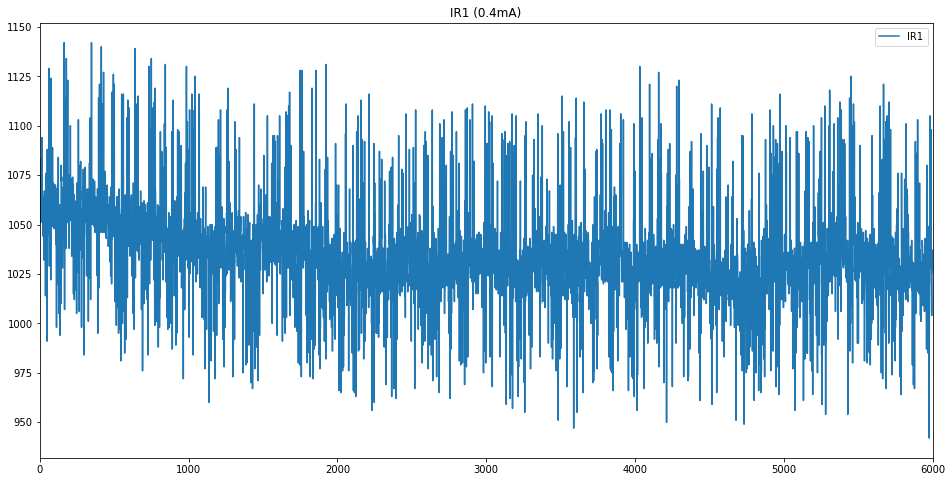

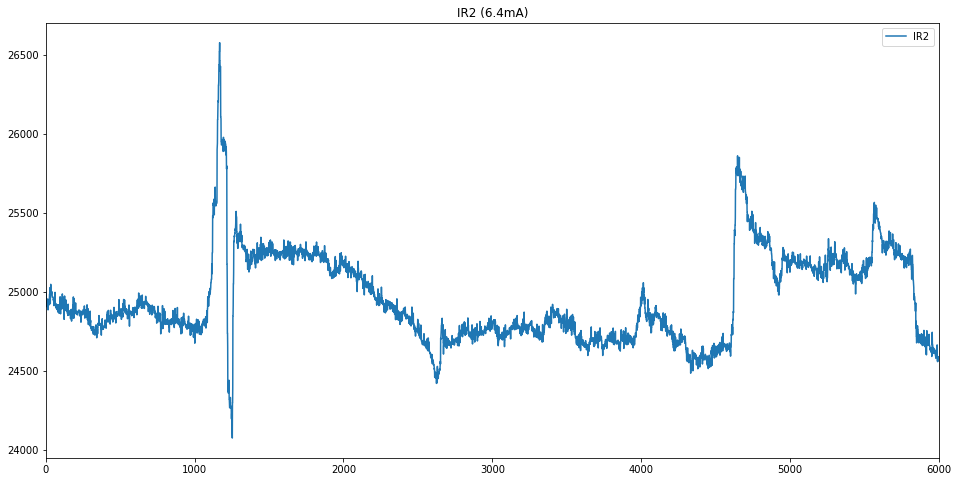

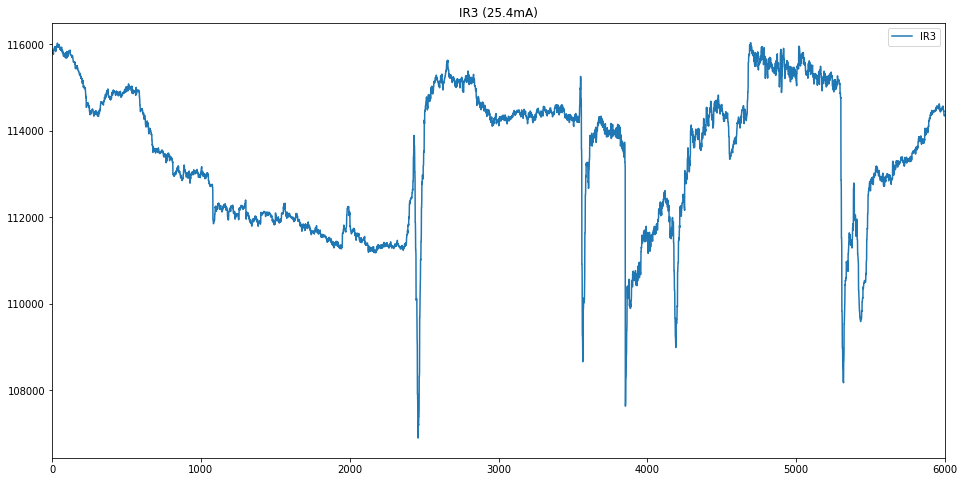

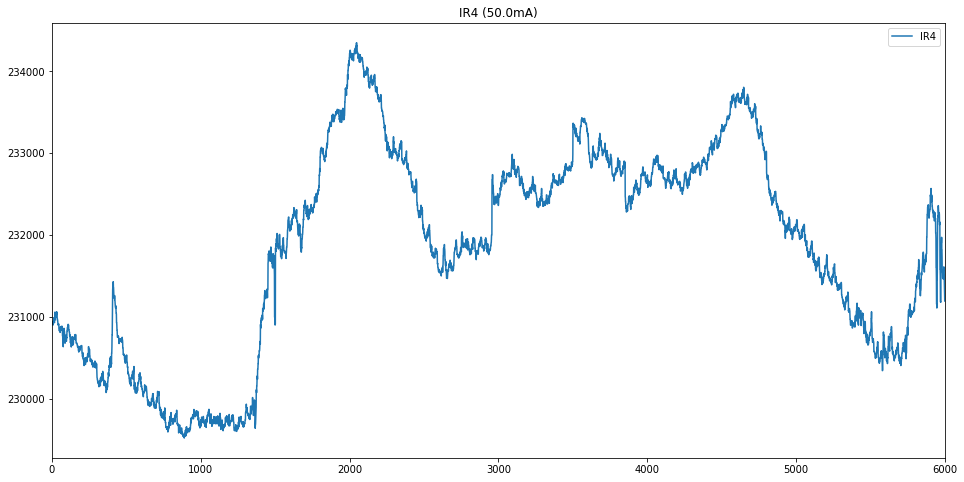

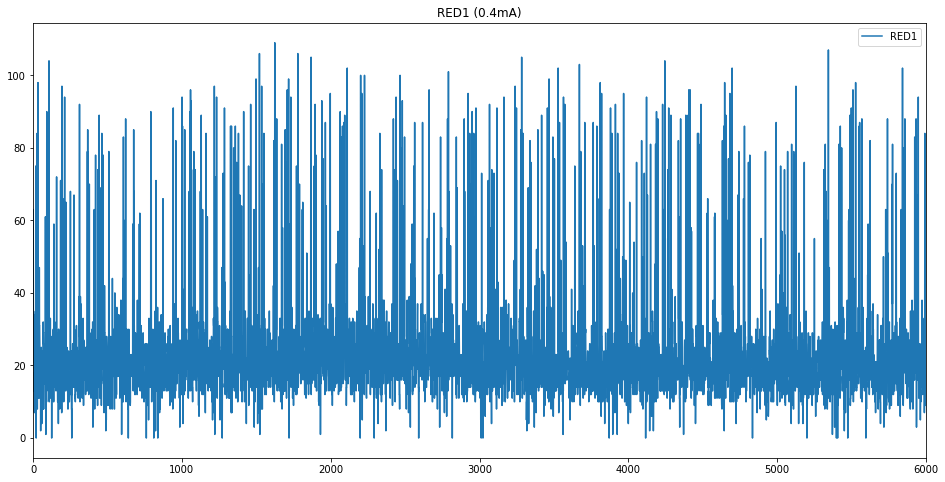

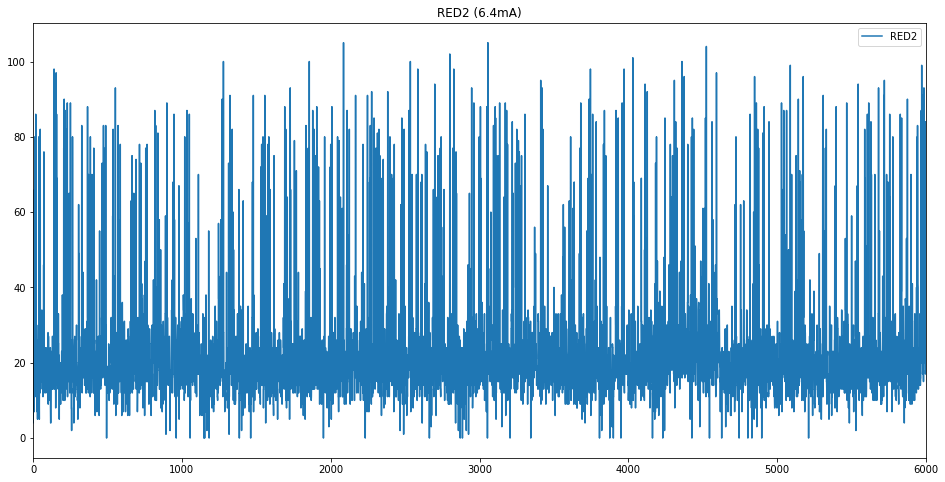

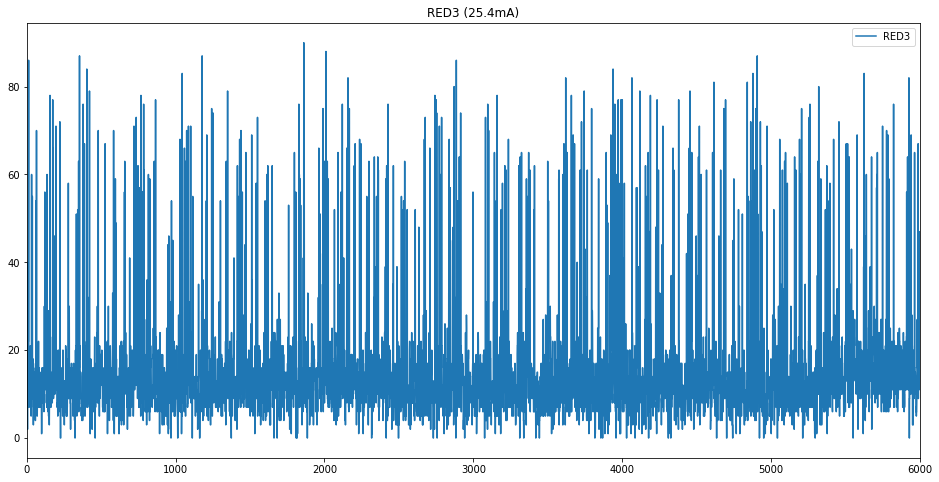

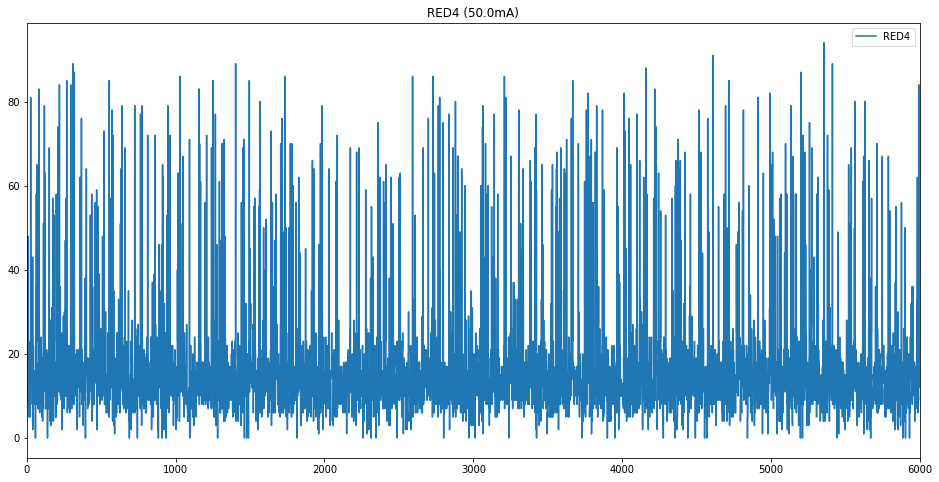

In [52]:
data.plot(y='IR1',title='IR1 (0.4mA)',figsize=(16,8))
data.plot(y='IR2',title='IR2 (6.4mA)',figsize=(16,8))
data.plot(y='IR3',title='IR3 (25.4mA)',figsize=(16,8))
data.plot(y='IR4',title='IR4 (50.0mA)',figsize=(16,8))
data.plot(y='RED1',title='RED1 (0.4mA)',figsize=(16,8))
data.plot(y='RED2',title='RED2 (6.4mA)',figsize=(16,8))
data.plot(y='RED3',title='RED3 (25.4mA)',figsize=(16,8))
data.plot(y='RED4',title='RED4 (50.0mA)',figsize=(16,8))
plt.show()

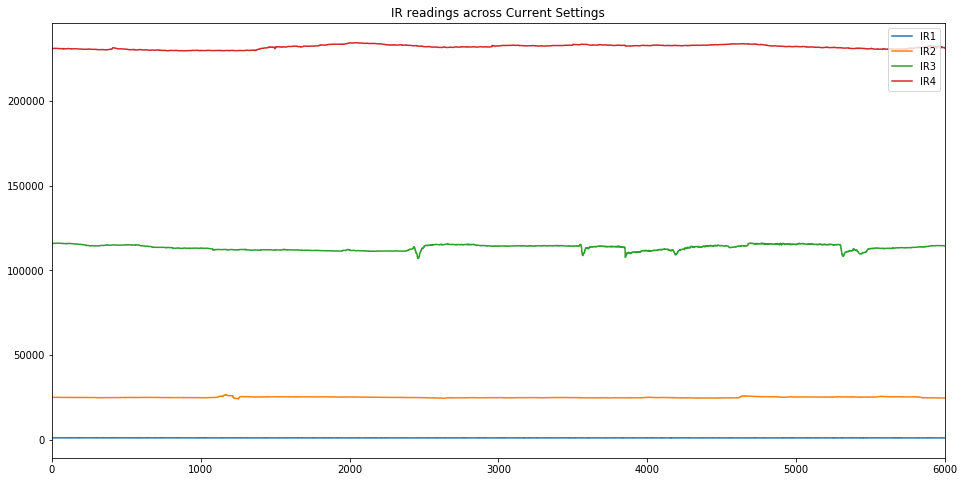

In [53]:
data.plot(y=['IR1','IR2','IR3','IR4'], title='IR readings across Current Settings',figsize=(16,8))
plt.show()

Above we can see from the times where my thumb shifted that lower IR values come with lower variance.

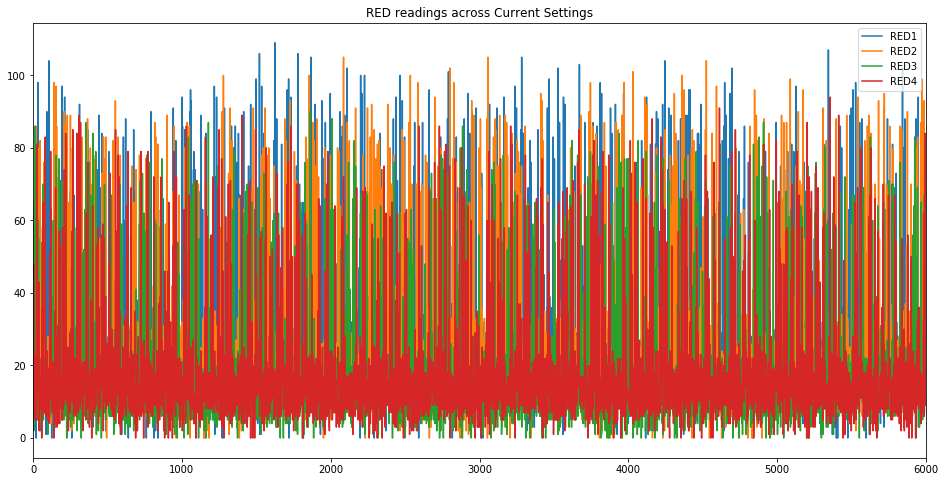

In [54]:
data.plot(y=['RED1','RED2','RED3','RED4'], title='RED readings across Current Settings',figsize=(16,8))
plt.show()

Red readings are very similar for different power levels.